In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('pretrained_model/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('pretrained_model/trfm_pretrained.pkl'))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('pretrained_model/rnn_pretrained.pkl'))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# HIV dataset

In [5]:
df = pd.read_csv('dataset/hiv.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(41127, 3)
SMILES is too long (220)
SMILES is too long (274)
SMILES is too long (247)
SMILES is too long (226)
SMILES is too long (244)
SMILES is too long (243)
SMILES is too long (253)
SMILES is too long (266)
SMILES is too long (346)
SMILES is too long (232)
SMILES is too long (242)
SMILES is too long (247)
SMILES is too long (240)
SMILES is too long (370)
SMILES is too long (224)
SMILES is too long (283)
SMILES is too long (265)
SMILES is too long (240)
SMILES is too long (219)
SMILES is too long (246)
SMILES is too long (243)
SMILES is too long (284)
SMILES is too long (270)
SMILES is too long (232)
SMILES is too long (260)
SMILES is too long (284)
SMILES is too long (284)
SMILES is too long (439)
SMILES is too long (491)
SMILES is too long (439)
SMILES is too long (296)
SMILES is too long (341)
SMILES is too long (285)
SMILES is too long (327)
SMILES is too long (341)
SMILES is too long (400)
SMILES is too long (263)
SMILES is too long (238)
SMILES is too long (383)
SMILES is too 

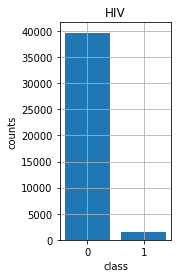

In [6]:
keys = ['0', '1']
bottom = df.groupby('HIV_active').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('HIV')
plt.grid()
plt.show()

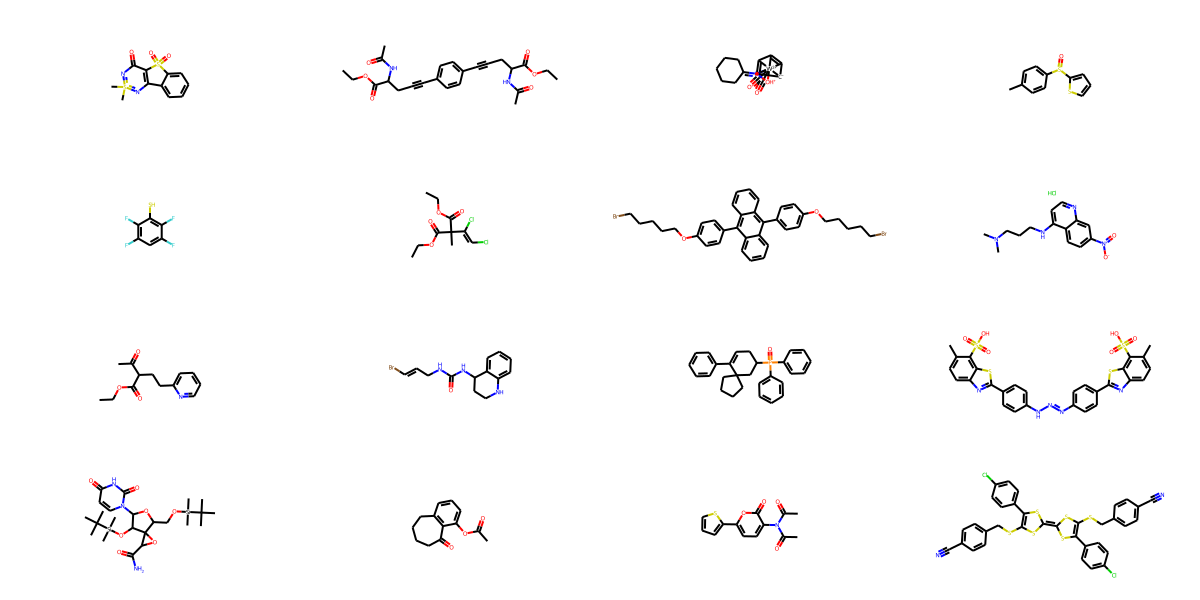

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['HIV_active'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.5045553978213884, 'roc_auc std': 0.029162596680380206, 'prc_auc mean': 0.044533228891260365, 'prc_auc std': 0.006495671263431431}
0.025 {'roc_auc mean': 0.4611841909730342, 'roc_auc std': 0.019966875986789746, 'prc_auc mean': 0.04435680309554482, 'prc_auc std': 0.0052889579823286615}
0.05 {'roc_auc mean': 0.4726066091470339, 'roc_auc std': 0.018113559369322442, 'prc_auc mean': 0.050663798088425735, 'prc_auc std': 0.004199988583965529}
0.1 {'roc_auc mean': 0.5109970094029791, 'roc_auc std': 0.014768272825643186, 'prc_auc mean': 0.06312551920647105, 'prc_auc std': 0.004653604407214549}
0.2 {'roc_auc mean': 0.563434345623431, 'roc_auc std': 0.011129156773222295, 'prc_auc mean': 0.07709298102167049, 'prc_auc std': 0.005687237012278599}
0.4 {'roc_auc mean': 0.5969711511835458, 'roc_auc std': 0.009164028678327916, 'prc_auc mean': 0.09266247028266825, 'prc_auc std': 0.007590049240520854}
0.8 {'roc_auc mean': 0.6259493881967553, 'roc_auc std': 0.015960833644211494, 'p

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['HIV_active'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.5787740111097383, 'roc_auc std': 0.01954794851969659, 'prc_auc mean': 0.06512346001612501, 'prc_auc std': 0.012532810380432989}
0.025 {'roc_auc mean': 0.5979575394541523, 'roc_auc std': 0.014200049703056002, 'prc_auc mean': 0.07965547330050851, 'prc_auc std': 0.01064985708554135}
0.05 {'roc_auc mean': 0.6042503593767836, 'roc_auc std': 0.01201526410209025, 'prc_auc mean': 0.0834141431726782, 'prc_auc std': 0.009317100382625907}
0.1 {'roc_auc mean': 0.6230828523772044, 'roc_auc std': 0.008511522890916506, 'prc_auc mean': 0.10998828334658244, 'prc_auc std': 0.011138563342014412}
0.2 {'roc_auc mean': 0.6389586031866197, 'roc_auc std': 0.007574354685842758, 'prc_auc mean': 0.14170026639547417, 'prc_auc std': 0.011798889042087974}
0.4 {'roc_auc mean': 0.6637017147546551, 'roc_auc std': 0.009034602462682291, 'prc_auc mean': 0.18048056562596332, 'prc_auc std': 0.012822179934605889}
0.8 {'roc_auc mean': 0.6988490678975827, 'roc_auc std': 0.014408894630924398, 'prc_auc

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['HIV_active'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.456125120650969, 'roc_auc std': 0.033545217439193996, 'prc_auc mean': 0.040657176923312804, 'prc_auc std': 0.006821324533143765}
0.025 {'roc_auc mean': 0.4657452921624543, 'roc_auc std': 0.03755374192595247, 'prc_auc mean': 0.04336041013018595, 'prc_auc std': 0.008432651122327385}
0.05 {'roc_auc mean': 0.48357779660918576, 'roc_auc std': 0.018596669295706796, 'prc_auc mean': 0.05104424240476513, 'prc_auc std': 0.00543445571968444}
0.1 {'roc_auc mean': 0.4945841896740612, 'roc_auc std': 0.017739724764267675, 'prc_auc mean': 0.05757376152073244, 'prc_auc std': 0.005536843888921388}
0.2 {'roc_auc mean': 0.5182823474844905, 'roc_auc std': 0.02293435152719808, 'prc_auc mean': 0.07150362927925716, 'prc_auc std': 0.008341729896646704}
0.4 {'roc_auc mean': 0.5492061704068112, 'roc_auc std': 0.018532691619902633, 'prc_auc mean': 0.09393556310839166, 'prc_auc std': 0.011302912076507925}
0.8 {'roc_auc mean': 0.5813091133332433, 'roc_auc std': 0.020498918911527834, 'prc_a

Classification evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_22452\149481803.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


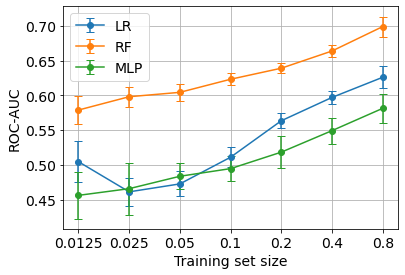

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 41127 molecules. It will take a little time.
(41127, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['HIV_active'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.6053819456009626, 'roc_auc std': 0.024470863964653197, 'prc_auc mean': 0.08380628622128193, 'prc_auc std': 0.021895401356711974}
0.025 {'roc_auc mean': 0.638794140534791, 'roc_auc std': 0.017662567753500683, 'prc_auc mean': 0.12082672133202954, 'prc_auc std': 0.01630463051529554}
0.05 {'roc_auc mean': 0.6746862539105805, 'roc_auc std': 0.015502825053742108, 'prc_auc mean': 0.1530013752620643, 'prc_auc std': 0.014390677358934635}
0.1 {'roc_auc mean': 0.7004686994423807, 'roc_auc std': 0.011410306441270822, 'prc_auc mean': 0.18364729499850213, 'prc_auc std': 0.01705375753727813}
0.2 {'roc_auc mean': 0.7312007303944036, 'roc_auc std': 0.008623065794773838, 'prc_auc mean': 0.22485034089660036, 'prc_auc std': 0.01112771756415122}
0.4 {'roc_auc mean': 0.7533670321216066, 'roc_auc std': 0.007771364965877523, 'prc_auc mean': 0.26207940866826346, 'prc_auc std': 0.010459758347816836}
0.8 {'roc_auc mean': 0.7713638065858601, 'roc_auc std': 0.013325094325927933, 'prc_auc 

ST + Random Forest Classifier

In [ ]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['HIV_active'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6033946401422562, 'roc_auc std': 0.009754459848497845, 'prc_auc mean': 0.08921906046735999, 'prc_auc std': 0.014968058777191161}
0.025 {'roc_auc mean': 0.6155075339030505, 'roc_auc std': 0.01985767295546689, 'prc_auc mean': 0.11187446100532328, 'prc_auc std': 0.025937856134023076}
0.05 {'roc_auc mean': 0.6331309621237186, 'roc_auc std': 0.009415342620048643, 'prc_auc mean': 0.13656776533175533, 'prc_auc std': 0.018138262395161853}
0.1 {'roc_auc mean': 0.6546628819553382, 'roc_auc std': 0.007869000290977157, 'prc_auc mean': 0.16247228772225308, 'prc_auc std': 0.01145412456668778}
0.2 {'roc_auc mean': 0.6753358349624612, 'roc_auc std': 0.008089481240267114, 'prc_auc mean': 0.20037107142858973, 'prc_auc std': 0.012658328711055503}
0.4 {'roc_auc mean': 0.7015184350140731, 'roc_auc std': 0.008837338497500508, 'prc_auc mean': 0.2419854205221527, 'prc_auc std': 0.011594760701690039}


ST + Multi-layer Perceptron Classifier (MLP)

In [ ]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['HIV_active'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

SMILES TRANSFORMER evaluation

In [ ]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/HIV_st_eval.png', dpi=300)
fig.show()

# Pre-training RNN model

In [ ]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

RNN + Logistic Regression

In [ ]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['HIV_active'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

RNN + Random Forest Classifier

In [ ]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['HIV_active'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

RNN + Multi-layer Perceptron Classifier (MLP)

In [ ]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['HIV_active'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

# Pre-training RNN Evaluation

In [ ]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

In [ ]:
Classification evaluation wih

In [ ]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/HIV_pretrain_eval.png', dpi=300)
fig.show()

# Visualization of the Latent Space

In [ ]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

In [ ]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

In [ ]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['p_np']==1][:,0], X_reduced[df['HIV_active']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['p_np']==0][:,0], X_reduced[df['HIV_active']==0][:,1], label='negative', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('figures/hiv.png', dpi=300)
plt.show()